Refrence: https://keras.io/examples/vision/siamese_network/, https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/siamese_network.ipynb

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
data_url = "/content/drive/MyDrive/AI_DataSets/siamese_network/faces"
cls_url = data_url+"/classification_data"
test_data_url = cls_url+"/test_data"
train_data_url = cls_url+"/train_data"
val_data_url = cls_url+"/val_data"

In [ ]:
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
import os
import random
import tensorflow as tf
from collections import defaultdict

In [ ]:
def preprocess_image(filename):

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, DIM) #just incase
    return image

def preprocess_triplets(anchor, positive, negative=None):
    if negative is None:
      return (
        preprocess_image(anchor),
        preprocess_image(positive),
        )
    return (
      preprocess_image(anchor),
      preprocess_image(positive),
      preprocess_image(negative),
      )
# def get_random_excluding(x=0,y=any,z=CATAGORY_LEN):
#   return random.rand(random.randint(0,y-1),random.randint(y+1,z))

# #add hoc method to get tripplets
# def get_triplet():
#   anchor_catagorical_index = random.randint(0,CATAGORY_LEN)
#   negative_catagorical_index = get_random_excluding(anchor_catagorical_index)

#   anchor_index = random.randint(0,len(train_imgs_cata[anchor_catagorical_index])-1)
#   anchor = train_imgs_cata[anchor_catagorical_index][anchor_index]
#   positive = train_imgs_cata[anchor_catagorical_index][get_random_excluding(anchor_index)]
#   negative = train_imgs_cata[negative_catagorical_index][random.randint(0,len(train_imgs_cata[negative_catagorical_index])-1)]
#   return preprocess_triplets(anchor,positive,negative)


In [ ]:
DIM=(64,64)

In [ ]:
import os
import random
from itertools import combinations

def get_triplets(url, cap=None):

    imgs_cata = {}
    train_dirs = sorted(os.listdir(url))
    for i, cls_name in enumerate(train_dirs):
        cls_dir = os.path.join(url, cls_name)
        imgs_cata[i] = [
            os.path.join(cls_dir, fname)
            for fname in sorted(os.listdir(cls_dir))
        ]

    triplet_paths = {}
    for key, imgs in imgs_cata.items():
        neg_keys = [k for k in imgs_cata if k != key]
        cap_slice = imgs if cap is None else imgs[:cap]

        triplet_paths[key] = []
        for a, p in combinations(cap_slice, 2):
            neg_cls = random.choice(neg_keys)
            n = random.choice(imgs_cata[neg_cls])
            triplet_paths[key].append((a, p, n))

    return triplet_paths


In [ ]:
import random
from itertools import combinations

# the cap can't be set more then the minimum amount of samples for the smallest class
# generic helper function to create triplets from duo url dictionarys (anchor and positive)

def get_triplets(url, cap=None):

  #creation of catagorical url dict
  imgs_cata = {}
  train_dirs = os.listdir(url)
  for i, dir in enumerate(train_dirs):
    imgs_cata[i] = []
    dir_url = url+"/"+dir
    _dir = os.listdir(dir_url)
    for img in _dir:
      imgs_cata[i].append(dir_url+"/"+img)

  #creating the processed triplets
  triplets_dict = {}
  for key,imgs in imgs_cata.items():
    neg_keys = list(imgs_cata.keys())
    neg_keys.remove(key)
    triplets_dict[key] = []
    for a, p in combinations(imgs[:cap], 2):
      neg_key = random.choice(neg_keys)
      triplets = (a,p, random.choice(imgs_cata[neg_key]))
      triplets_dict[key].append(triplets)

  return triplets_dict

In [ ]:
#https://www.tensorflow.org/guide/data_performance
def make_triplet_dataset(triplets_dict, batch_size=32, shuffle=True):

    #flattern dictionary
    triplets = []
    for trips in triplets_dict.values():
        for trip in trips:
            triplets.append(trip)

    # triplets: list of (a_path, p_path, n_path)
    ds = tf.data.Dataset.from_tensor_slices(triplets)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(triplets))

    # Now each element is a single 1-D tensor [a, p, n]
    # this allows deligation of another more compute to this task via multithreading
    # autotune can deligate more weight to compute in the form of parralel calls
    ds = ds.map(
        lambda trip: preprocess_triplets(trip[0], trip[1], trip[2]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_paths = get_triplets(train_data_url, cap=50)

ds_train = make_triplet_dataset(train_paths, batch_size=32, shuffle=True)

In [ ]:
print(len(train_paths))

4000


In [ ]:
val_paths = get_triplets(val_data_url)
ds_val = make_triplet_dataset(train_paths, batch_size=32, shuffle=False)

In [ ]:
print(len(ds_val))

150067


In [ ]:
test_paths = get_triplets(test_data_url)
test_val = make_triplet_dataset(test_paths, batch_size=32, shuffle=False)

KeyboardInterrupt: 

In [ ]:
import csv

def save_data_to_csv(data_url, data):
  #data_url+"train_imgs_triplets.csv"
  with open(data_url, "w", newline="") as f:
      writer = csv.writer(f)
      writer.writerow(["anchor", "positive", "negative"])  # header
      for key in data:
          for a, p, n in data[key]:
            writer.writerow([a, p, n])


def load_triplets_from_csv(csv_path):
    """
    Reads a CSV with header ['anchor','positive','negative']
    and returns a list of (anchor_path, positive_path, negative_path) tuples.
    """
    triplets = []
    with open(csv_path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            triplets.append((row["anchor"], row["positive"], row["negative"]))
    return triplets


In [ ]:
save_data_to_csv(data_url+"train_imgs_triplets_full.csv", ds_train)

KeyboardInterrupt: 

In [ ]:
save_data_to_csv(data_url+"train_imgs_triplets_val_50.csv", ds_val)

TypeError: '_PrefetchDataset' object is not subscriptable

In [ ]:
print(ds_train[0])

TypeError: '_PrefetchDataset' object is not subscriptable

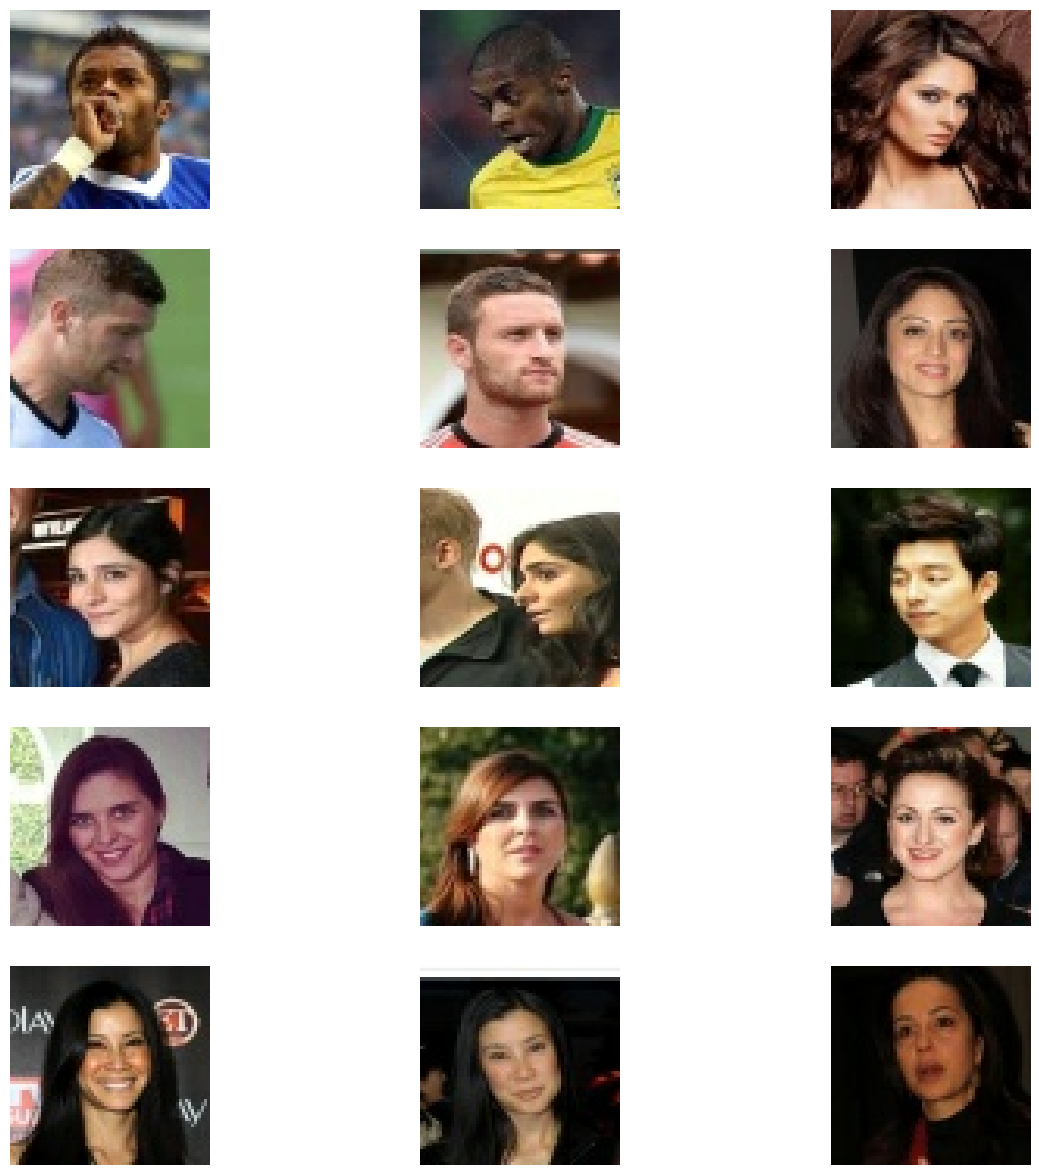

In [ ]:
def visualize_batch(anchors, positives, negatives, n=3):
    def show(ax, img):
        ax.imshow(img)
        ax.axis('off')

    fig, axs = plt.subplots(n, 3, figsize=(3*n, 3*n))
    for i in range(n):
        show(axs[i,0], anchors[i])
        show(axs[i,1], positives[i])
        show(axs[i,2], negatives[i])
    plt.show()

# batch based processing with tensor.data
anchors, positives, negatives = next(iter(ds_train))
visualize_batch(anchors, positives, negatives, n=5)

In [ ]:
# https://www.digitalocean.com/community/tutorials/global-pooling-in-convolutional-neural-networks

base_cnn = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=DIM+(3,),
    pooling=None,
    classes=4000,
    classifier_activation='softmax'
)


# base_cnn = tf.keras.applications.ResNet50(
#     weights="imagenet", input_shape=DIM + (3,), include_top=False
# )

from tensorflow.keras import Model, layers

x = layers.GlobalAveragePooling2D()(base_cnn.output) #globalaveragepooling is used in cnn with great effect
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64)(x)
# https://stackoverflow.com/questions/59596162/how-to-apply-l2-normalization-to-a-layer-in-keras
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

# generic embedding model
embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

embedding.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,812,864 (94.65 MB)

 Trainable params: 10,154,688 (38.74 MB)

 Non-trainable params: 14,658,176 (55.92 MB)

In [ ]:
pp_in = tf.keras.applications.resnet.preprocess_input
ops = tf.keras.ops
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

#input layers
anchor_input = layers.Input(name="anchor", shape=DIM + (3,))
positive_input = layers.Input(name="positive", shape=DIM + (3,))
negative_input = layers.Input(name="negative", shape=DIM + (3,))

# embedding towers
distances = DistanceLayer()(
    embedding(pp_in(anchor_input)),
    embedding(pp_in(positive_input)),
    embedding(pp_in(negative_input)),
)
# multi input model with predefined sub models
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
metrics = tf.keras.metrics
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.

        #tape records a sequence of events used to find _compute_loss(data)
        #this will be used to go back through the gradient and calculate the
        #differnce between the results,
        #mathematicly its using the chain rule to compute the changes in weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            #creates iterating tupples
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        # this is euclian distance between 3, or triplet loss
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        # this is euclian distance between 3, or triplet loss
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
# siamese_model.fit(ds_train, epochs=10, validation_data=ds_val)

In [ ]:
# assuming you flattened your dict into train_paths and val_paths lists:
batch_size = 32

# total number of triplets
train_samples = len(ds_val)
val_samples   = len(val_paths) # i want less here

# how many batches per epoch so you cover every sample once
steps_per_epoch   = train_samples // batch_size
validation_steps  = val_samples   // batch_size

print(f"Training on {train_samples} samples → {steps_per_epoch} steps/epoch")
print(f"Validating on {val_samples} samples → {validation_steps} steps/epoch")

siamese_model.fit(
    ds_train,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_val,
    validation_steps=validation_steps
)


Training on 150067 samples → 4689 steps/epoch
Validating on 4000 samples → 125 steps/epoch
Epoch 1/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 4856s 1s/step - loss: 0.4406 - val_loss: 0.4144
Epoch 2/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 1508s 322ms/step - loss: 0.3978 - val_loss: 0.4134
Epoch 3/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 920s 196ms/step - loss: 0.3910 - val_loss: 0.4253
Epoch 4/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 706s 151ms/step - loss: 0.3890 - val_loss: 0.4015
Epoch 5/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 657s 140ms/step - loss: 0.3823 - val_loss: 0.3948
Epoch 6/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 600s 128ms/step - loss: 0.3832 - val_loss: 0.4005
Epoch 7/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 554s 118ms/step - loss: 0.3783 - val_loss: 0.4024
Epoch 8/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 541s 115ms/step - loss: 0.3805 - val_loss: 0.4042
Epoch 9/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 535s 114ms/step - loss: 0.3774 - val_loss: 0.3972
Epoch 10/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 523s 112ms/step - loss: 0.3783 - val_lo

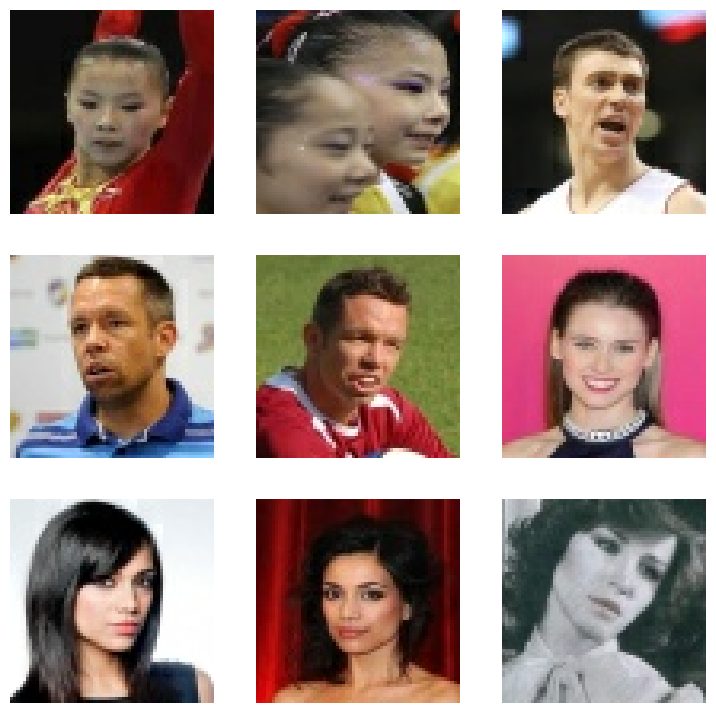

In [ ]:
from keras.applications import resnet

def visualize_batch(anchors, positives, negatives, n=3):
    def show(ax, img):
        ax.imshow(img)
        ax.axis('off')

    fig, axs = plt.subplots(n, 3, figsize=(3*n, 3*n))
    for i in range(n):
        show(axs[i,0], anchors[i])
        show(axs[i,1], positives[i])
        show(axs[i,2], negatives[i])
    plt.show()

anchors, positives, negatives = next(iter(ds_train))
visualize_batch(anchors, positives, negatives, n=3)

# setting the embeding for each of A P and N
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Cosine Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Cosine Negative similarity", negative_similarity.numpy())

Cosine Positive similarity: 0.87437755
Cosine Negative similarity 0.80952394


Cosine Positive similarity: 0.87437755  
Cosine Negative similarity 0.80952394  
Positives have a closer similariy then negatives

Indicates that margin may be to wide, data set is pretty similar (the negatives are other faces NOT things that look like faces.)  
Try to train on 0.1 or 0.2 margin

In [ ]:
# higher similarity is higher

In [ ]:
# def euclidean_disance_mean(set_x,set_y):
#   total = 0
#   count = 0
#   for x, y in zip(set_x,set_y):
#     total += tf.norm(x-y)
#     count += 1
#   mean = total/count
#   return mean

# There is a slight difference, it may be more effcient to use?
def euclidean_distance_mean(set_x, set_y):
    distances = tf.norm(set_x - set_y, axis=1)
    return tf.reduce_mean(distances)


positive_similarity = euclidean_distance_mean(anchor_embedding, positive_embedding)
print("Euclidean Positive similarity:", positive_similarity.numpy())

negative_similarity = euclidean_distance_mean(anchor_embedding, negative_embedding)
print("Euclidean Negative similarity", negative_similarity.numpy())

Euclidean Positive similarity: 0.41533333
Euclidean Negative similarity 0.63670325


Good result, Positives are closer then negatives

Mine:  
Euclidean Positive similarity: 0.41533336  
Euclidean Negative similarity 0.63670325

TF:  
Euclidean Positive similarity: 0.41533333  
Euclidean Negative similarity 0.63670325

Epoch 1/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 526s 111ms/step - loss: 0.3740 - val_loss: 0.3988
Epoch 2/10
2542/4689 ━━━━━━━━━━━━━━━━━━━━ 3:47 106ms/step - loss: 0.3773

KeyboardInterrupt: 

Training on 150067 samples → 4689 steps/epoch
Validating on 4000 samples → 125 steps/epoch
Epoch 1/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 4856s 1s/step - loss: 0.4406 - val_loss: 0.4144
Epoch 2/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 1508s 322ms/step - loss: 0.3978 - val_loss: 0.4134
Epoch 3/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 920s 196ms/step - loss: 0.3910 - val_loss: 0.4253
Epoch 4/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 706s 151ms/step - loss: 0.3890 - val_loss: 0.4015
Epoch 5/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 657s 140ms/step - loss: 0.3823 - val_loss: 0.3948
Epoch 6/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 600s 128ms/step - loss: 0.3832 - val_loss: 0.4005
Epoch 7/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 554s 118ms/step - loss: 0.3783 - val_loss: 0.4024
Epoch 8/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 541s 115ms/step - loss: 0.3805 - val_loss: 0.4042
Epoch 9/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 535s 114ms/step - loss: 0.3774 - val_loss: 0.3972
Epoch 10/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 523s 112ms/step - loss: 0.3783 - val_loss: 0.4126
<keras.src.callbacks.history.History at 0x7d2d7e5de350>


In [ ]:
# batch size, DIM, col channels
# siamese_model.build((batch_size, 64, 64, 3))

# siamese_model.save_weights(data_url+"/siamese_weights.weights.h5")
siamese_model.save(data_url+"/siamese_full.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


needs to run on l4 to compute

ref: https://www.baeldung.com/cs/euclidean-distance-vs-cosine-similarity  
Cosine Similarity: angular distace bewteen 2 vectors in vector space, where the angles, where the circles centre is at the origin.  
Euclidean distance:the distance between 2 vectors in vector space  
L2_norm is messuing from the diffrence between the origin and the vector, but its the same equasion as euclidean

plot ROC & PR AUC: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

I'll use cosin similarity to classify the images using the mean = 0.87437755 as my threshold

In [ ]:
print(val_paths[0])

[('/content/drive/MyDrive/AI_DataSets/siamese_network/faces/classification_data/val_data/n006972/0286_01.jpg', '/content/drive/MyDrive/AI_DataSets/siamese_network/faces/classification_data/val_data/n006972/0189_01.jpg', '/content/drive/MyDrive/AI_DataSets/siamese_network/faces/classification_data/val_data/n008329/0394_03.jpg')]


In [ ]:
# use this for the actual program!

# # train paths is unshuffled, meaning we can easily do a classification error
# # its also only has 1 validation set per class so its easy

# anchors, positives, negatives = next(iter(ds_val))
# anchor_embedding, positive_embedding, negative_embedding = (
#     embedding(resnet.preprocess_input(anchor)),
#     embedding(resnet.preprocess_input(positive)),
#     embedding(resnet.preprocess_input(negative)),
# )
# def cosign_classifier(a,p):
#   mean = 0.87437755
#   if cosine_similarity(a,p) < mean:
#     return False
#   else:
#     return True

# classifaction_set_accuracy = {}
# i = 0
# for a, p in zip(anchor_embedding, positive_embedding):
#   classifaction_set_accuracy[i] = cosine_similarity(a,p)
#   i += 1


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# on a per pair basis
def cosine_similarity_pairs(a, b):
    a = tf.math.l2_normalize(a, axis=0)
    b = tf.math.l2_normalize(b, axis=0)
    return tf.reduce_sum(a * b).numpy()

positive_scores = []
negative_scores = []

for a, p in zip(anchor_embedding, positive_embedding):
    score = cosine_similarity_pairs(a, p)
    positive_scores.append(score)

for a, n in zip(anchor_embedding, negative_embedding):
    score = cosine_similarity_pairs(a, n)
    negative_scores.append(score)

labels = [1] * len(positive_scores) + [0] * len(negative_scores)
scores = positive_scores + negative_scores


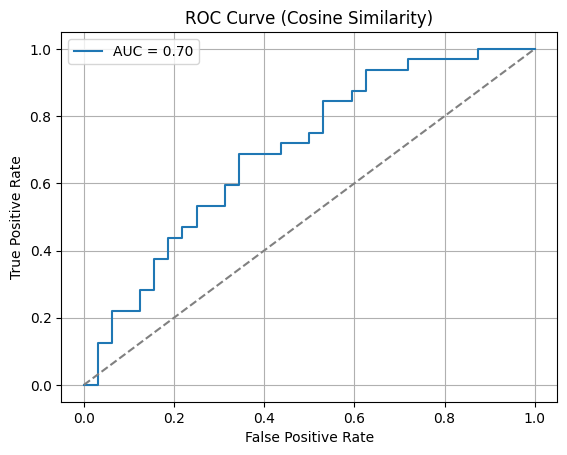

In [ ]:
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Cosine Similarity)")
plt.legend()
plt.grid(True)
plt.show()


Model is showing that it will likely produce true positives, its higher then  the middle line which is somewhat of a coin flip, since the AUC is .7 the  accuracy is about 70%

Extract embedding wieghts from main seimese mode, load new weights into single embedding model and cover to onnx format

In [ ]:
!pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
siamese_model = SiameseModel(siamese_network, margin=0.5)
siamese_model.build((tf.zeros((1,64,64,3)),
                   tf.zeros((1,64,64,3)),
                   tf.zeros((1,64,64,3))))
siamese_model.load_weights(data_url + "/siamese_weights.weights.h5")
embedding = siamese_model.siamese_network.get_layer("Embedding")

In [ ]:
import tf2onnx
import onnx

input_signature = [tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)]
onnx_model, _ = tf2onnx.convert.from_keras(embedding, input_signature, opset=13)
onnx.save(onnx_model, data_url+"/embedding.onnx")